## MNIST in Keras with Tensorboard

This sample trains an "MNIST" handwritten digit 
recognition model on a GPU or TPU backend using a Keras
model. Data are handled using the tf.data.Datset API. This is
a very simple sample provided for educational purposes. Do
not expect outstanding TPU performance on a dataset as
small as MNIST.

### Parameters

In [1]:
BATCH_SIZE = 64
LEARNING_RATE = 0.002
# GCS bucket for training logs and for saving the trained model
# You can leave this empty for local saving, unless you are using a TPU.
# TPUs do not have access to your local instance and can only write to GCS.
BUCKET="gs://ml1-demo-martin/mnist" # a valid bucket name must start with gs://

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### Imports

In [2]:
import os, re, math, json, time
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.platform import tf_logging
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0-dlenv


## TPU/GPU detection

In [3]:
try: # detect TPUs
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
  strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)
    
# adjust batch size and learning rate for distributed computing
global_batch_size = BATCH_SIZE * strategy.num_replicas_in_sync # num replcas is 8 on a single TPU or N when runing on N GPUs.
learning_rate = LEARNING_RATE * strategy.num_replicas_in_sync

INFO:tensorflow:Initializing the TPU system: martin-tpuv3-8-tf22


INFO:tensorflow:Initializing the TPU system: martin-tpuv3-8-tf22


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


In [4]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  unbatched_train_ds = training_dataset.unbatch()
  
  if tf.executing_eagerly():
      # This is the TF 2.0 "eager execution" way of iterating through a tf.data.Dataset
      for v_images, v_labels in validation_dataset:
        break

      for t_images, t_labels in unbatched_train_ds.batch(N):
        break

      validation_digits = v_images.numpy()
      validation_labels = v_labels.numpy()
      training_digits   = t_images.numpy()
      training_labels   = t_labels.numpy()
  else:
    # This is the legacy TF 1.x way of iterating through a tf.data.Dataset
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = unbatched_train_ds.batch(N).make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

### Colab-only auth for this notebook and the TPU

In [5]:
#IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
#if IS_COLAB_BACKEND:
#  from google.colab import auth
#  auth.authenticate_user() # Authenticates the backend and also the TPU using your credentials so that they can access your private GCS buckets

### tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/guide/performance/datasets) input pipelines with tf.data.Dataset

In [6]:
def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, global_batch_size)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

### Let's have a look at the data

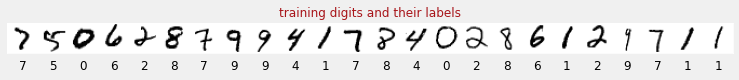

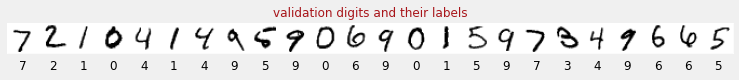

In [7]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Keras model: 3 convolutional layers, 2 dense layers

In [8]:
# This model trains to 99.4%— sometimes 99.5%— accuracy in 10 epochs (with a batch size of 64)

def make_model():
    
    model = tf.keras.Sequential(
      [
        tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),

        tf.keras.layers.Conv2D(filters=6, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=12, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),
          
        tf.keras.layers.Dense(200, use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
          
        tf.keras.layers.Dropout(0.5), # Dropout on dense layer only
        tf.keras.layers.Dense(10, activation='softmax')
      ])

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    
with strategy.scope(): # the new way of handling distribution strategies in Tensorflow 1.14+
    model = make_model()

# print model layers
model.summary()
                        
# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learning_rate * math.pow(0.5, 1+epoch) + learning_rate/200, verbose=True)

# set up Tensorboard logs
timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")
log_dir=os.path.join(BUCKET, 'mnist-logs', timestamp)
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=50*global_batch_size)
print("Tensorboard loggs written to: ", log_dir)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         54        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         18        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 12)        2592      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 12)        36        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 12)        0

### Train and validate the model

In [9]:
EPOCHS = 10
steps_per_epoch = 60000//global_batch_size  # 60,000 items in this dataset
print("Step (batches) per epoch: ", steps_per_epoch)
  
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                            validation_data=validation_dataset, validation_steps=1, callbacks=[lr_decay, tb_callback])

Step (batches) per epoch:  117

Epoch 00001: LearningRateScheduler reducing learning rate to 0.00808.
Epoch 1/10
  2/117 [..............................] - ETA: 2:33 - accuracy: 0.3652 - loss: 2.0532WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (1.480141). Check your callbacks.


  3/117 [..............................] - ETA: 1:51 - accuracy: 0.5026 - loss: 1.6069WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.304145). Check your callbacks.


117/117 [==============================] - 8s 66ms/step - accuracy: 0.9394 - loss: 0.2027 - val_accuracy: 0.9049 - val_loss: 0.2827 - lr: 0.0081

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00408.
Epoch 2/10
  1/117 [..............................] - ETA: 0s - accuracy: 0.9746 - loss: 0.0785WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.257462). Check your callbacks.


117/117 [==============================] - 3s 25ms/step - accuracy: 0.9805 - loss: 0.0649 - val_accuracy: 0.9300 - val_loss: 0.1997 - lr: 0.0041

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0020800000000000003.
Epoch 3/10
  1/117 [..............................] - ETA: 0s - accuracy: 0.9805 - loss: 0.0725WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.242580). Check your callbacks.


117/117 [==============================] - 3s 26ms/step - accuracy: 0.9865 - loss: 0.0452 - val_accuracy: 0.9813 - val_loss: 0.0663 - lr: 0.0021

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00108.
Epoch 4/10
  1/117 [..............................] - ETA: 0s - accuracy: 0.9883 - loss: 0.0391WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.280624). Check your callbacks.


117/117 [==============================] - 3s 25ms/step - accuracy: 0.9898 - loss: 0.0345 - val_accuracy: 0.9902 - val_loss: 0.0293 - lr: 0.0011

Epoch 00005: LearningRateScheduler reducing learning rate to 0.00058.
Epoch 5/10
  1/117 [..............................] - ETA: 0s - accuracy: 1.0000 - loss: 0.0158WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.299909). Check your callbacks.


117/117 [==============================] - 3s 25ms/step - accuracy: 0.9913 - loss: 0.0296 - val_accuracy: 0.9913 - val_loss: 0.0256 - lr: 5.8000e-04

Epoch 00006: LearningRateScheduler reducing learning rate to 0.00033.
Epoch 6/10
  1/117 [..............................] - ETA: 0s - accuracy: 0.9941 - loss: 0.0163WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.226687). Check your callbacks.


117/117 [==============================] - 3s 26ms/step - accuracy: 0.9924 - loss: 0.0260 - val_accuracy: 0.9920 - val_loss: 0.0239 - lr: 3.3000e-04

Epoch 00007: LearningRateScheduler reducing learning rate to 0.000205.
Epoch 7/10
  1/117 [..............................] - ETA: 0s - accuracy: 1.0000 - loss: 0.0088WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.216980). Check your callbacks.


117/117 [==============================] - 3s 26ms/step - accuracy: 0.9931 - loss: 0.0234 - val_accuracy: 0.9920 - val_loss: 0.0241 - lr: 2.0500e-04

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0001425.
Epoch 8/10
  1/117 [..............................] - ETA: 0s - accuracy: 0.9922 - loss: 0.0230WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.234824). Check your callbacks.


117/117 [==============================] - 3s 24ms/step - accuracy: 0.9928 - loss: 0.0228 - val_accuracy: 0.9918 - val_loss: 0.0232 - lr: 1.4250e-04

Epoch 00009: LearningRateScheduler reducing learning rate to 0.00011125000000000001.
Epoch 9/10
  1/117 [..............................] - ETA: 0s - accuracy: 0.9941 - loss: 0.0190WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.251358). Check your callbacks.


117/117 [==============================] - 3s 26ms/step - accuracy: 0.9938 - loss: 0.0223 - val_accuracy: 0.9922 - val_loss: 0.0230 - lr: 1.1125e-04

Epoch 00010: LearningRateScheduler reducing learning rate to 9.562500000000001e-05.
Epoch 10/10
  1/117 [..............................] - ETA: 0s - accuracy: 0.9961 - loss: 0.0154WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.249420). Check your callbacks.


117/117 [==============================] - 3s 25ms/step - accuracy: 0.9940 - loss: 0.0215 - val_accuracy: 0.9922 - val_loss: 0.0226 - lr: 9.5625e-05


### Visualize predictions

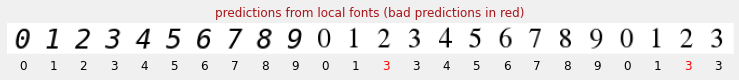

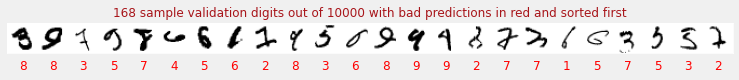

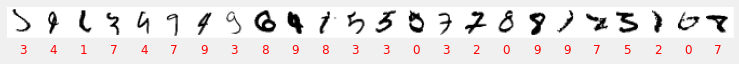

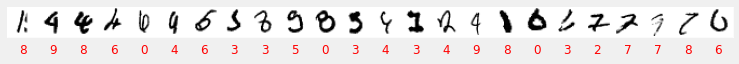

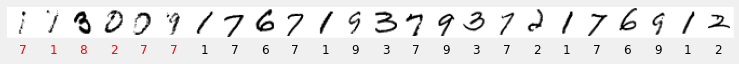

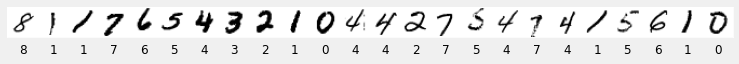

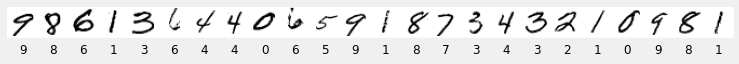

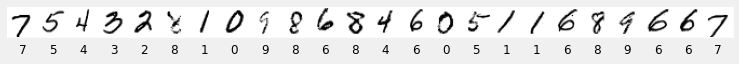

In [11]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
